In [1]:
from delayed_paper import *
plt.style.use(['dark_background'])

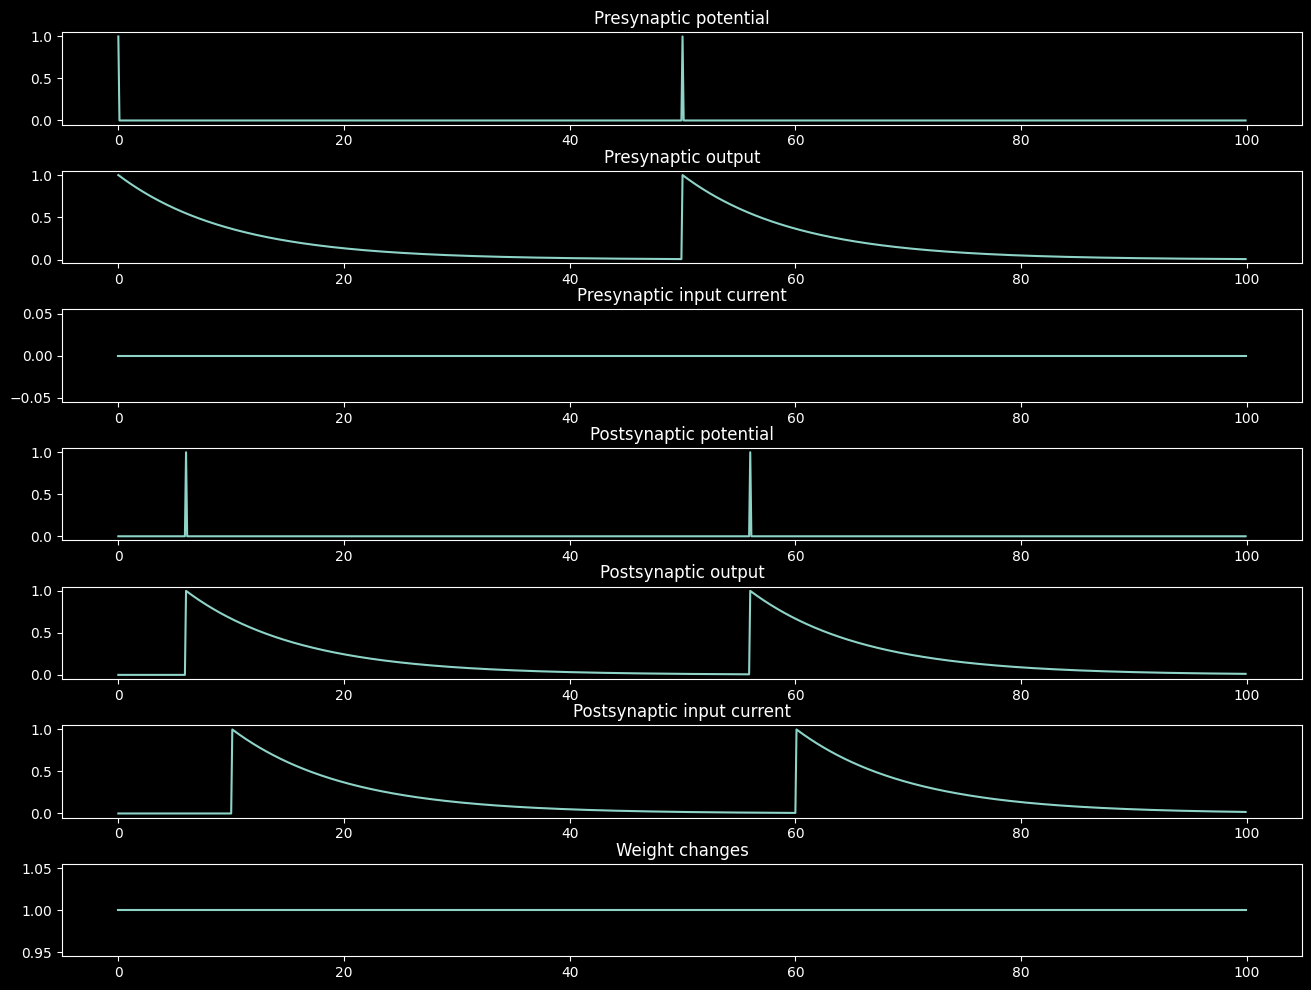

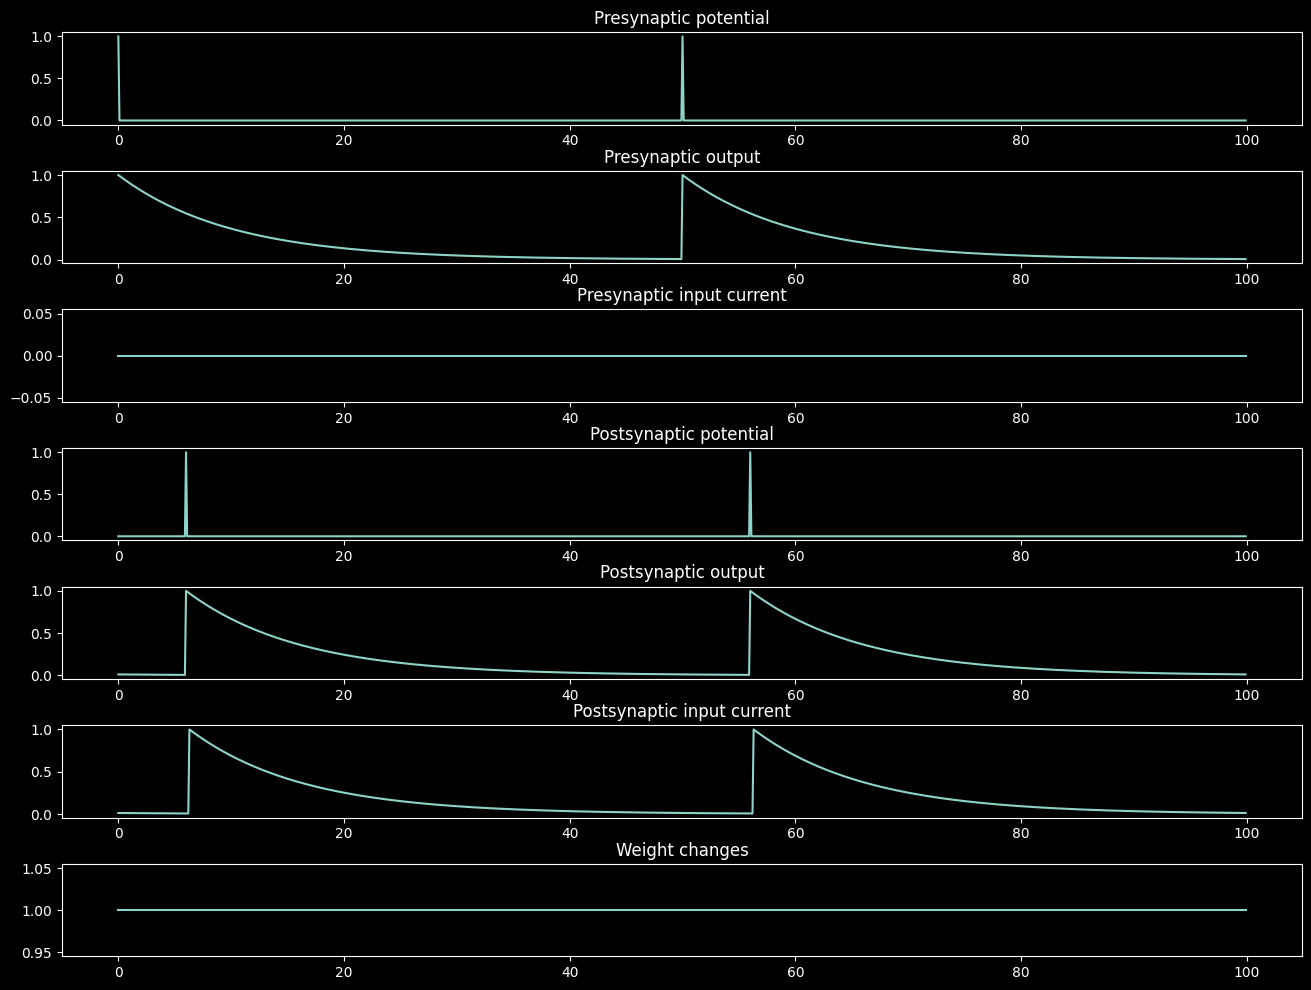

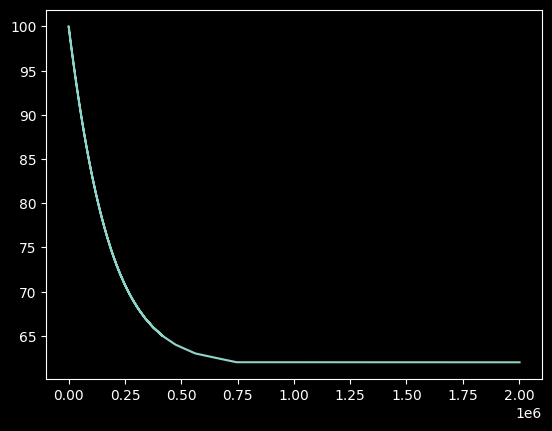

In [2]:
model_11 = exp11()
model_11.show_config()
delay_all = []
model_11, delay, dd = protocol_11(model_11)
delay_all += delay
model_11, delay, dd = protocol_11(model_11, time=200000, plot=False)
delay_all += delay
model_11, delay, dd = protocol_11(model_11)
delay_all += delay
plt.plot(delay_all)

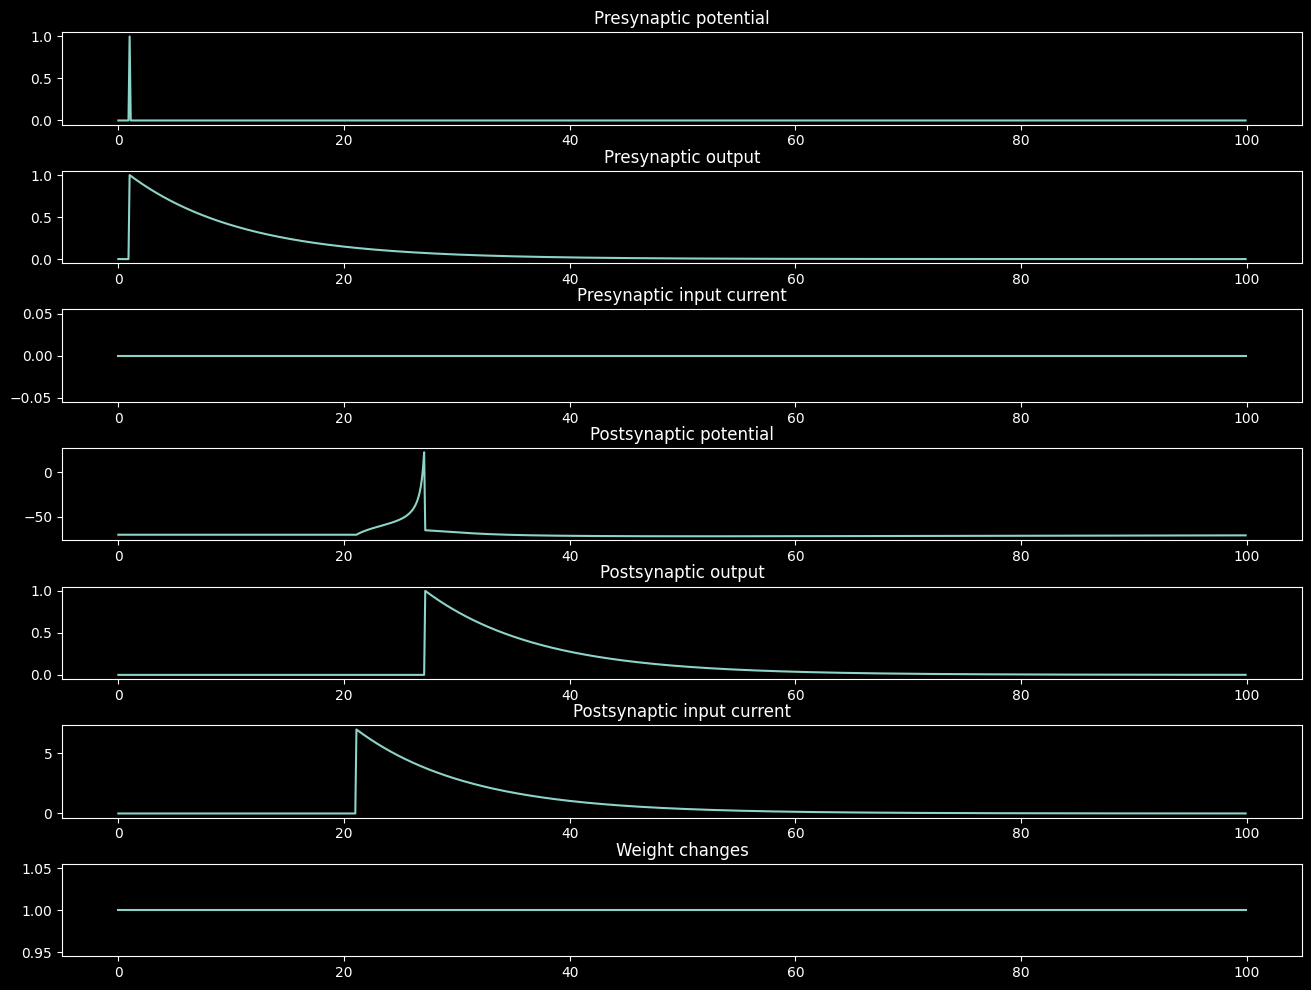

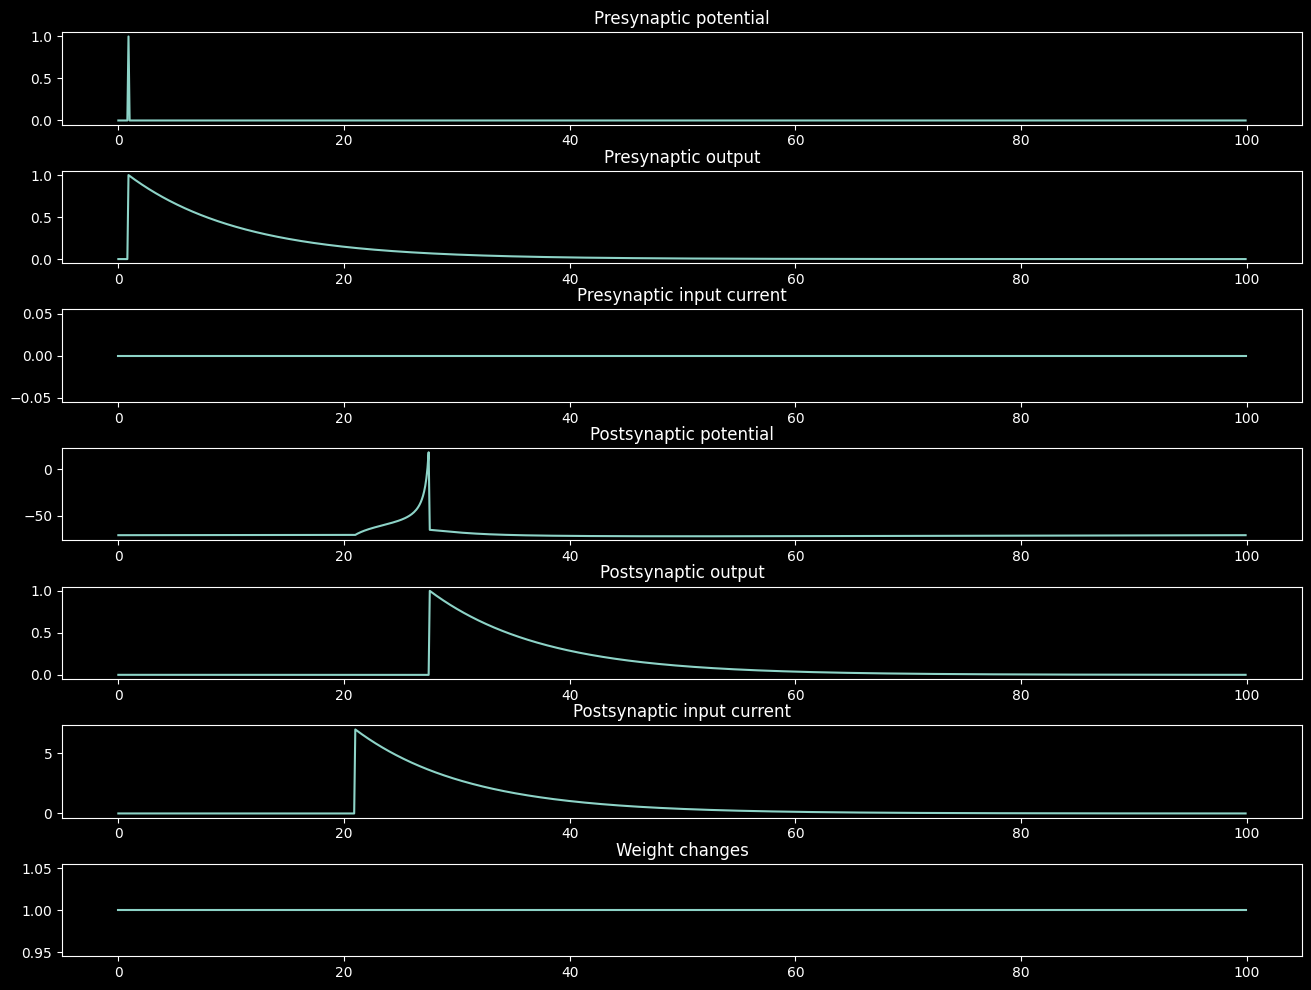

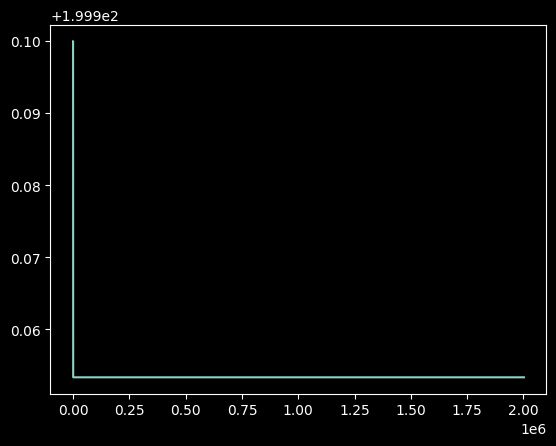

In [3]:
model_12 = exp12()
model_12.show_config()
delay_all = []
model_11, delay, dd = protocol_12(model_12)
delay_all += delay
model_11, delay, dd = protocol_12(model_12, time=200000, plot=False)
delay_all += delay
model_11, delay, dd = protocol_12(model_12)
delay_all += delay
plt.plot(delay_all)

In [4]:
patterns, num_inputs, num_patterns = sampler()
patterns, num_inputs, num_patterns

({0: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
  1: [5, 6, 3, 9, 1, 4, 7, 10, 8, 2],
  2: [5, 6, 10, 9, 7, 3, 4, 2, 8, 1],
  3: [3, 2, 9, 1, 7, 4, 6, 10, 5, 8]},
 10,
 3)

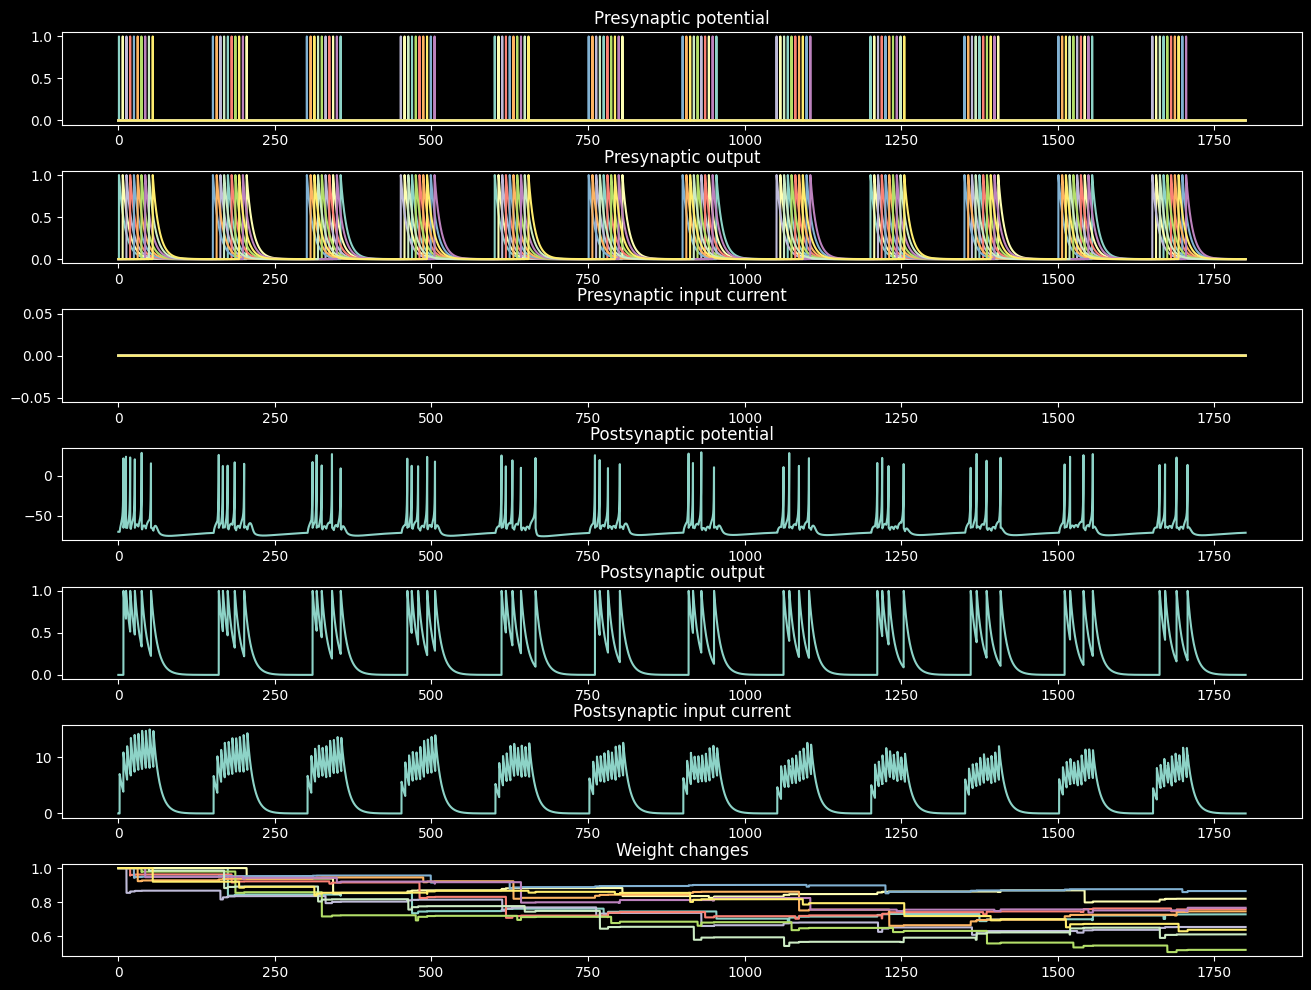

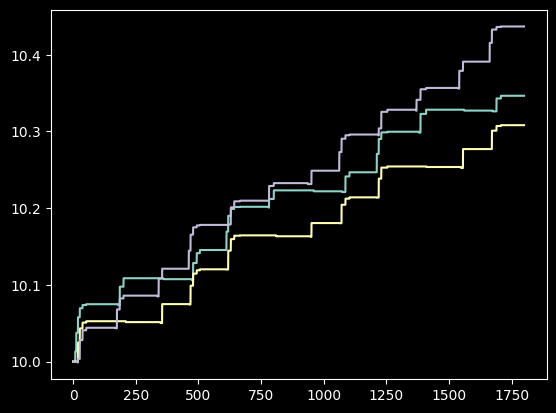

In [5]:
model_21 = exp21()
model_21.show_config()
model, delay, dd = run_protocol(exp21(), sampler=patterns, gather_data=True, plot=True, freeze_delays=False, plast_type='t_stdp')
plt.figure()
if delay.size > 0:
    for i in range(num_patterns):
        plt.plot(np.array(range(len(delay[i])))*.1, delay[i])
    plt.show()

In [ ]:
%load_ext autoreload
%autoreload 2
from model import *
from neurons import *
from synaptics import *
from utils import *
from protocols import *
from shallow_models import *
from vis_functions import *
res = .1
plt.style.use(['dark_background'])

### Experiment 1


##### 1.1. synapse of pseudoneurons


In [ ]:
# Initializing model
def exp11():
    snn = SNNModel()
    rt = 50
    output = Spikes_at_will(awaiting_time=6, refresh_time=rt, tau=10, synaptic_limit=1)
    input = Spikes_at_will(awaiting_time=0, refresh_time=rt, tau=10, synaptic_limit=1)
    synapse = Delayed_synapse(input, output, scale=1, delay=10, max_delay=100, b=0)
    snn.add_neuron(output)
    snn.add_neuron(input)
    snn.add_synapse(synapse)
    snn.reload_graph()
    return snn
model_11 = exp11()
model_11.show_config()

In [ ]:
def protocol_11(model, time=100, plot=True):
    delay = []
    dd = []
    gatherer = Gatherer(model)
    t = np.arange(int(time/res)) * res
    for i in t:
        model.tick()
        if plot:
            gatherer.gather_stats()
        delay.append(model.syn_by_edge[1,0].delay)
        dd.append(model.syn_by_edge[1,0].dd)
    if plot:
        draw_stats_gatherer(*gatherer.get_stats(pre_ids=[1], post_ids=[0]), t)
    return model, delay, np.array(dd)

delay_all = []
model_11, delay, dd = protocol_11(model_11)
delay_all += delay
model_11, delay, dd = protocol_11(model_11, time=200000, plot=False)
delay_all += delay
model_11, delay, dd = protocol_11(model_11)
delay_all += delay
plt.plot(delay_all)

##### 1.2. Izhikevich on postsynapse

In [ ]:
def exp12(sc=7):
    # OPTIMAL PARAMS FOR 0 IMPACT:
    # rt0 = 100, aw0 = 1, tau = 10, delay = 0 (any, in fact), b = 6.7
    snn = SNNModel()
    rt0 = 100 # msec
    aw0 = 1 # msec
    output = Izhikevich(tau=10, synaptic_limit=1)
    input = Spikes_at_will(awaiting_time=aw0, refresh_time=rt0, synaptic_limit=1, tau=10)
    syn = Delayed_synapse(input, output, scale=sc, delay=20, max_delay=100, d_lr=1, b=6.7)
    snn.add_neuron(output)
    snn.add_neuron(input)
    snn.add_synapse(syn)
    snn.reload_graph()
    return snn
model_12 = exp12()
model_12.show_config()

In [ ]:
def protocol_12(model, time=100, plot=True):
    delay = []
    dd = []
    gatherer = Gatherer(model)
    t = np.arange(int(time/res)) * res
    for i in t:
        model.tick()
        if plot:
            gatherer.gather_stats()
        delay.append(model.syn_by_edge[1,0].delay)
        dd.append(model.syn_by_edge[1,0].dd)
    if plot:
        draw_stats_gatherer(*gatherer.get_stats(pre_ids=[1], post_ids=[0]), t)
    return model, delay, np.array(dd)

delay_all = []
model_11, delay, dd = protocol_12(model_12)
delay_all += delay
model_11, delay, dd = protocol_12(model_12, time=200000, plot=False)
delay_all += delay
model_11, delay, dd = protocol_12(model_12)
delay_all += delay
plt.plot(delay_all)

### Experiment 2


In [ ]:
# Some general preparations
num_inputs = 3

num_rand_patterns = 2
num_patterns = num_rand_patterns + 1
assert num_rand_patterns < np.math.factorial(num_inputs) - 1, 'too many patterns for an input of this size'

# Sampler
sequence = np.arange(num_inputs) + 1
patterns = {}
patterns[0] = sequence.tolist()
for p in range(1, num_rand_patterns+2):
    seq = sequence.copy()
    np.random.shuffle(seq)
    seq = seq.tolist()
    if seq not in patterns.values():
        patterns[p] = seq
    else:
        while seq in patterns.values():
            np.random.shuffle(seq)
            if seq not in patterns.values():
                patterns[p] = seq
                break
patterns

In [ ]:
def run_protocol(model, num_patterns=num_patterns, sampler=patterns, sample_time=150,
          interval=6, runs=3, lr=.1, freeze_delays=False, gather_data=False, plot=False,
          plast_type=None):
    model.set_rule_to_all(plast_type)
    model.set_lr_to_all(lr)
    delay = [[] for i in range(num_inputs)]
    dd = [[] for i in range(num_inputs)]
    if gather_data:
        gatherer = Gatherer(model)
    for run in range(runs):
        for p in range(num_patterns):
            sample = sampler[p]
            aw = 1
            for neu in sample:
                model.neurons[neu].awaiting_time = aw
                model.neurons[neu].refresh()
                aw += interval
            for t in np.arange(int(sample_time/res)) * res:
                model.tick(freeze_delays=freeze_delays)
                if gather_data:
                    gatherer.gather_stats()
                    if not freeze_delays:
                        for edge in range(1, num_inputs+1):
                            delay[edge-1].append(model.syn_by_edge[edge,0].delay)
                            dd[edge-1].append(model.syn_by_edge[edge,0].dd)
    if plot:
        draw_stats_gatherer(*gatherer.get_stats(pre_ids=list(range(1, num_inputs+1)), post_ids=[0]), time_range=sample_time*runs*num_patterns, resolution=res)
    return model, np.array(delay), np.array(dd)

##### Delayed Izhikevich many-to-one

In [ ]:
def exp21(sc=7, num_inputs=num_inputs):
    snn = SNNModel()
    output = Izhikevich(tau=10, synaptic_limit=1)
    snn.add_neuron(output)
    for saw in range(num_inputs):
        neu = Spikes_at_will(tau=10, synaptic_limit=1)
        snn.add_neuron(neu)
        syn = Delayed_synapse(neu, output, scale=sc, delay=1, max_delay=100, d_lr=1, b=4.6)
        snn.add_synapse(syn)
    snn.reload_graph()
    return snn
model_21 = exp21()
model_21.show_config()

In [ ]:
model, delay, dd = run_protocol(exp21(), gather_data=True, plot=True, freeze_delays=False, plast_type='t_stdp')
plt.figure()
if delay.size > 0:
    for i in range(num_patterns):
        plt.plot(np.array(range(len(delay[i])))*.1, delay[i])
    plt.show()

##### Pair-STDP model

In [ ]:
def exp22(sc=7, num_inputs=10):
    snn = SNNModel()
    output = Izhikevich(tau=30, synaptic_limit=1)
    snn.add_neuron(output)
    for weighted in range(num_inputs):
        neu = Spikes_at_will()
        snn.add_neuron(neu)
        syn = Synapse(neu, output, scale=sc)
        snn.add_synapse(syn)
    snn.reload_graph()
    return snn
model_22 = exp22()
model_22.show_config()

In [ ]:
model, delay, dd = run_protocol(exp21(), gather_data=True, plot=True, freeze_delays=True, plast_type='pair_stdp')
plt.figure()
if delay.size > 0:
    for i in range(num_patterns):
        plt.plot(list(range(len(delay[i]))), delay[i])
    plt.show()

##### tSTDP model

In [ ]:
model_23 = exp22()
model_22.show_config()

In [ ]:
model, delay, dd = run_protocol(exp21(), gather_data=True, plot=True, freeze_delays=True, plast_type='t_stdp')
plt.figure()
if delay.size > 0:
    for i in range(num_patterns):
        plt.plot(list(range(len(delay[i]))), delay[i])
    plt.show()